In [23]:
import numpy as np  # for array stuff and random
from PIL import Image  # for creating visual of our env
import cv2  # for showing our visual live
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
import pickle  # to save/load Q-Tables
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box

style.use("ggplot")  # setting our style!

In [24]:
SIZE = 20

In [25]:
HM_EPISODES = 25000
ENEMY_PENALTY = 300  # feel free to tinker with these!
FOOD_REWARD = 25  # feel free to tinker with these!
epsilon = 0.25  # randomness
EPS_DECAY = 0.995  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 1000  # how often to play through env visually.
MOVE_PENALTY = 1

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict! Using just for colors
d = {1: (0, 0, 255),  # Attacker (red)
     2: (0, 255, 0),  # Target (green)
     3: (255, 175, 0)}  # Defender (blue)

In [26]:
class AdversarialEnv(Env):
    def __init__(self):
      # Create the edge parameters for our Box Environmnet
      self.x_min = 0
      self.x_max = 20
      self.y_min = 0
      self.y_max = 20
      
      #Define our attacker, defender and target
      self.attacker = self.Attacker()
      self.defender = self.Defender()
      self.target = self.Target()

      # Create our action space such that there is 8 movements (this would be all surrounding boxes to the current box)
      self.action_space = Discrete(8)

      #Create the Observation Space using our provided edge parameters
      self.observation_space = Box(low=np.array([self.x_min, self.y_min]), high=np.array([self.x_max, self.y_max]))

    def reset(self):
        #Initialize all players position on the board
    
        self.x_attacker = np.random.randint(0, 3)
        self.y_attacker = np.random.randint(0, 3)
        self.x_defender = np.random.randint(7, 15)
        self.y_defender = np.random.randint(7, 15)
        self.x_target = np.random.randint(16, 20)
        self.y_target = np.random.randint(16, 20)

        self.state = np.array([self.x_attacker, self.y_attacker, self.x_defender, self.y_defender, self.x_target, self.y_target])

        return self.state

    def step(self, action):
        if action == 0:
            new_obs = self.move(x=0, y=1)
        elif action == 1:
            new_obs = self.move(x=1, y=0)
        elif action == 2:
            new_obs = self.move(x=1, y=1)
        elif action == 3:
            new_obs = self.move(x=-1, y=0)
        elif action == 4:
            new_obs = self.move(x=-1, y=1)
        elif action == 5:
            new_obs = self.move(x=-1, y=-1)
        elif action == 6:
            new_obs = self.move(x=1, y=-1)
        elif action == 7:
            new_obs = self.move(x=0, y=-1)

        self.state = np.array([self.x, self.y])

        return self.state, -1, False, None

    
        
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

In [27]:
class Attacker(Env):
    def __init__(self):
        self.action_space = Discrete(8)
        self.x_min = 0
        self.x_max = 20
        self.y_min = 0
        self.y_max = 20
        self.observation_space = Box(low=np.array([self.x_min, self.y_min]), high=np.array([self.x_max, self.y_max]))

    def step(self, action):
        if action == 0:
            new_obs = self.move(x=0, y=1)
        elif action == 1:
            new_obs = self.move(x=1, y=0)
        elif action == 2:
            new_obs = self.move(x=1, y=1)
        elif action == 3:
            new_obs = self.move(x=-1, y=0)
        elif action == 4:
            new_obs = self.move(x=-1, y=1)
        elif action == 5:
            new_obs = self.move(x=-1, y=-1)
        elif action == 6:
            new_obs = self.move(x=1, y=-1)
        elif action == 7:
            new_obs = self.move(x=0, y=-1)

        self.state = np.array([self.x, self.y])

        return self.state, -1, False, None
        
    def reset(self):
        #If we want to make it like a real Gym Env then get rid of x1, x2, y1, y2
        self.x = np.random.randint(0, 3)
        self.y = np.random.randint(0, 3)
        self.state = np.array([self.x, self.y])

        return self.state
        
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

class Defender(Env):
    def __init__(self):
        self.action_space = Discrete(8)
        self.x_min = 0
        self.x_max = 20
        self.y_min = 0
        self.y_max = 20
        self.observation_space = Box(low=np.array([self.x_min, self.y_min]), high=np.array([self.x_max, self.y_max]))

    def step(self, action):
        if action == 0:
            new_obs = self.move(x=0, y=1)
        elif action == 1:
            new_obs = self.move(x=1, y=0)
        elif action == 2:
            new_obs = self.move(x=1, y=1)
        elif action == 3:
            new_obs = self.move(x=-1, y=0)
        elif action == 4:
            new_obs = self.move(x=-1, y=1)
        elif action == 5:
            new_obs = self.move(x=-1, y=-1)
        elif action == 6:
            new_obs = self.move(x=1, y=-1)
        elif action == 7:
            new_obs = self.move(x=0, y=-1)

        self.state = np.array([self.x, self.y])

        return self.state, -1, False, None
        
    def reset(self):
        #If we want to make it like a real Gym Env then get rid of x1, x2, y1, y2
        self.x = np.random.randint(7,15)
        self.y = np.random.randint(7,15)
        self.state = np.array([self.x, self.y])

        return self.state
        
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

class Target(Env):
    def __init__(self):
        self.action_space = Discrete(8)
        self.x_min = 0
        self.x_max = 20
        self.y_min = 0
        self.y_max = 20
        self.observation_space = Box(low=np.array([self.x_min, self.y_min]), high=np.array([self.x_max, self.y_max]))

    def step(self, action):
        if action == 0:
            new_obs = self.move(x=0, y=1)
        elif action == 1:
            new_obs = self.move(x=1, y=0)
        elif action == 2:
            new_obs = self.move(x=1, y=1)
        elif action == 3:
            new_obs = self.move(x=-1, y=0)
        elif action == 4:
            new_obs = self.move(x=-1, y=1)
        elif action == 5:
            new_obs = self.move(x=-1, y=-1)
        elif action == 6:
            new_obs = self.move(x=1, y=-1)
        elif action == 7:
            new_obs = self.move(x=0, y=-1)

        self.state = np.array([self.x, self.y])

        return self.state, -1, False, None
        
    def reset(self):
        #If we want to make it like a real Gym Env then get rid of x1, x2, y1, y2
        self.x = np.random.randint(16,20)
        self.y = np.random.randint(16,20)
        self.state = np.array([self.x, self.y])

        return self.state
        
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1


In [28]:
attacker = Attacker()
target = Target()
defender = Defender()

attacker.reset()
target.reset()
defender.reset()

print(attacker.x, attacker.y)
print(target.x, target.y)
attacker.step(2)

1 2
18 18


/Users/dw/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(array([2, 3]), -1, False, None)

In [29]:
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

print(q_table[((-9, -2), (3, 9))])

[-2.0364111799972, -4.127940603852702, -3.988287919262627, -0.13746282756817596]


on #0, epsilon is 7.111215029462243e-08
1000 ep mean: nan
on #1000, epsilon is 4.731780136335944e-10
1000 ep mean: -426.361
on #2000, epsilon is 3.1485116349120605e-12
1000 ep mean: -423.409
on #3000, epsilon is 2.09500974887917e-14
1000 ep mean: -434.036
on #4000, epsilon is 1.3940129041388684e-16
1000 ep mean: -421.493
on #5000, epsilon is 9.275718062626299e-19
1000 ep mean: -424.583
on #6000, epsilon is 6.172033653481947e-21
1000 ep mean: -431.789
on #7000, epsilon is 4.106851799776226e-23
1000 ep mean: -416.79
on #8000, epsilon is 2.732686283363049e-25
1000 ep mean: -435.149
on #9000, epsilon is 1.8183208665302858e-27
1000 ep mean: -422.697
on #10000, epsilon is 1.2099049912127034e-29
1000 ep mean: -425.151
on #11000, epsilon is 8.050669794901279e-32
1000 ep mean: -419.264
on #12000, epsilon is 5.356890385382476e-34
1000 ep mean: -435.313
on #13000, epsilon is 3.564458030458198e-36
1000 ep mean: -426.303
on #14000, epsilon is 2.371779173523419e-38
1000 ep mean: -413.99
on #15000, e

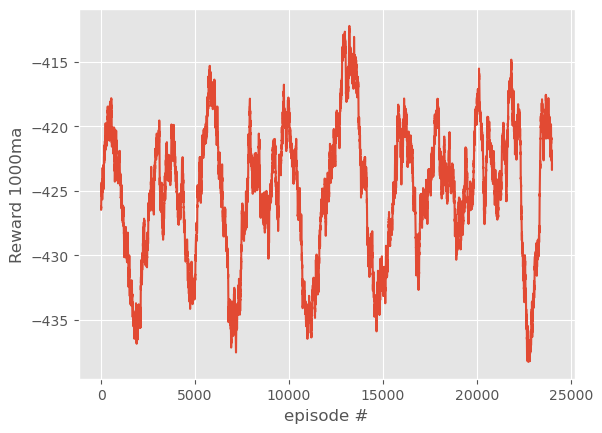

: 

In [33]:
env = Attacker()
target = Target()
defender = Defender()

episode_rewards = []

for episode in range(HM_EPISODES):
    
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    
    done = False
    episode_reward = 0

    attacker_obs = attacker.reset()
    target_state = target.reset()
    defender_obs = defender.reset()

    step = 0
    while not done:

        action = np.random.randint(0, 7)
        # Take the action!
        new_attacker_obs, _, _, _ = attacker.step(action)
        new_defender_obs, _, _, _ = defender.step(action)
        
        if attacker.x == defender.x and attacker.y == defender.y:
            reward = -ENEMY_PENALTY
        elif attacker.x == target.x and attacker.y == target.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        '''
        max_future_q = np.max(new_player_obs, player_obs)  # max Q value for this new obs
        current_q = q_table[player_obs][action]  # current Q for our chosen action

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        '''
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[target.x][target.y] = d[FOOD_N]  # sets the food location tile to green color
            env[attacker.x][attacker.y] = d[PLAYER_N]  # sets the player tile to blue
            env[defender.x][defender.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY or step>= 200:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

        if step >= 200:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)
